In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
import pyarrow.parquet as pq
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

In [216]:
DATA_PATH = r"C:\Users\zoopy\code\review-assist\data\yelp_academic_dataset_review.json"
WRITE_PATH = r"C:\Users\zoopy\code\review-assist\data\yelp_academic_dataset_review_short.json"
FINAL_WRITE_PATH = r"C:\Users\zoopy\code\review-assist\data\yelp_restaurant_reviews.parquet"
FINAL_WRITE_PATH_TRAIN = r"C:\Users\zoopy\code\review-assist\data\yelp_restaurant_reviews_train.parquet"
FINAL_WRITE_PATH_TEST = r"C:\Users\zoopy\code\review-assist\data\yelp_restaurant_reviews_test.parquet"
ALREADY_DATA = False
ACTUALLY_TRAIN = False

5    133282
4     75164
3     33989
1     33403
2     24162
Name: stars, dtype: int64
--------------------------------------------------
review_id      300000
user_id        300000
business_id    300000
stars          300000
useful         300000
funny          300000
cool           300000
text           300000
date           300000
dtype: int64


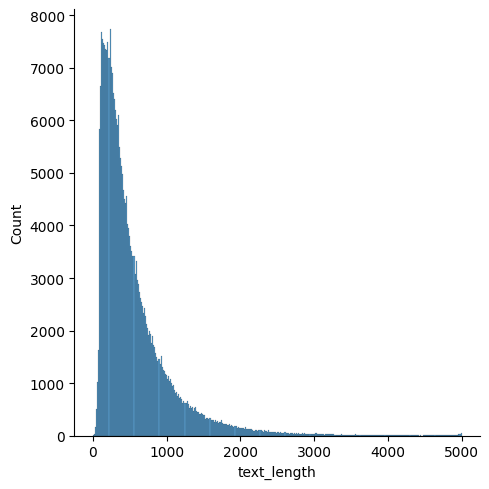

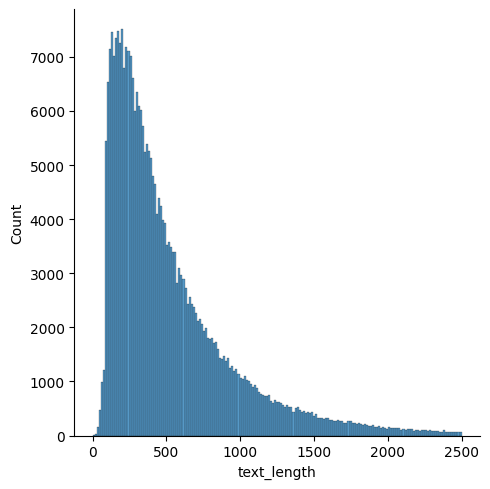

In [215]:
if not ALREADY_DATA:
    with open(DATA_PATH, mode='r', encoding='utf8') as in_file, \
        open(WRITE_PATH, mode='w', encoding='utf8') as out_file:
            for i in range(300000):
                out_file.write(next(in_file))
    df = pd.read_json(WRITE_PATH, lines=True)
    print(df["stars"].value_counts())
    print("-"*50)
    print(df.count())

    df['text_length'] = df['text'].apply(len)
    sns.displot(df,x='text_length')
    
    df = df.loc[df['text_length'] <= 2500]
    df["stars"] -= 1
    
    sns.displot(df,x='text_length')
    train, test = train_test_split(df, test_size=0.1)
    train.to_parquet(FINAL_WRITE_PATH_TRAIN)
    test.to_parquet(FINAL_WRITE_PATH_TEST)
else:
    df = pd.read_parquet(FINAL_WRITE_PATH_TRAIN)
    df_test = pd.read_parquet(FINAL_WRITE_PATH_TEST)

In [217]:
if not ACTUALLY_TRAIN:
    df = df.sample(n=5000)

In [227]:
def preprocess(input_text, tokenizer):
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        padding = "max_length",
                        max_length=64,
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

# Initialize Bert Tokenizer
tokenizer = BertTokenizerFast.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True)

text = df.text.values
labels = df.stars.values

token_id = []
attention_masks = []

for sample in tqdm(text):
  encoding_dict = preprocess(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=5).to(torch.float)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2396.36it/s]


In [197]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 5,
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [199]:
validation_ratio = 0.2
batch_size = 16

train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = 0.2,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [200]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [202]:
# Pytorch training
# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08)

# Run on GPU
model.cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 4

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  50%|██████████████████████████████████████▌                                      | 1/2 [00:29<00:29, 29.49s/it]


	 - Train loss: 0.3842
	 - Validation Accuracy: 0.0317
	 - Validation Precision: 0.1000
	 - Validation Recall: 0.0323
	 - Validation Specificity: 0.9628



Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.57s/it]


	 - Train loss: 0.2884
	 - Validation Accuracy: 0.0325
	 - Validation Precision: 0.2037
	 - Validation Recall: 0.1422
	 - Validation Specificity: 0.8613



In [212]:
inputs = tokenizer("What a cute sdf!", return_tensors="pt")
model.cpu()
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()

In [213]:
predicted_class_id

4

In [ ]:
# class YelpRestaurantDataset(Dataset):
#     def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_length: int = 512):
#         self.data = data
#         self.tokenizer = tokenizer
#         self.max_token_length = max_token_length
    
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index: int):
#         row = self.data.iloc[index]
#         input_text = row.text
#         labels = row.stars
#         encoding = tokenizer.encode_plus(
#                             input_text,
#                             add_special_tokens = True,
#                             padding = "max_length",
#                             max_length = self.max_token_length,
#                             truncation = True,
#                             return_attention_mask = True,
#                             return_tensors = 'pt'
#                        )
#         print(labels)
#         return dict(
#             input_text = input_text,
#             input_ids = encoding["input_ids"].flatten(),
#             attention_mask = encoding["attention_mask"].flatten(),
#             labels = torch.tensor(labels)
#         )

# dataset = YelpRestaurantDataset(df, tokenizer)

# Hugging Face Training (Not used for now)
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=5,
#     weight_decay=0.01,
# )

# trainer = Trainer(
#     model,
#     args,
#     train_dataset=encoded_dataset["train"],
#     eval_dataset=encoded_dataset[validation_key],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )